In [2]:
handle = 'sunnydopia@live.co.kr' 
pwd = '*helloimys90'

In [22]:
keyword= '곱창'   #검색할 키워드
num_of_pages = 30 #몇 번 스크롤 할 건지; e.g. 200 --> 1730개 게시글 긁어짐

In [23]:
#모듈 임포트
from selenium import webdriver
from urllib.parse import quote
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd 
import re
import folium
import numpy as np


# 1. 크롤링

In [24]:
#URL 가져오기
def InstagramUrlFromKeyword (browser,keyword,num_of_pagedowns):
    keyword_url_encode=quote(keyword)
    url='https://www.instagram.com/explore/tags/'+keyword+'/?hl=ko'
    browser.get(url)
    time.sleep(3)
    login = browser.find_element_by_xpath('//*[@id="react-root"]/section/nav/div[2]/div/div/div[3]/div/span/a[1]/button')
    login.click()
    time.sleep(3)
    user_id = browser.find_element_by_class_name('_2hvTZ.pexuQ.zyHYP')
    pw = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/article/div/div[1]/div/form/div[3]/div/label/input')
    user_id.send_keys(handle)
    pw.send_keys(pwd)
    button = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/article/div/div[1]/div/form/div[4]/button')
    button.click()
    time.sleep(3)
    arr_href=[]
    body=browser.find_element_by_tag_name('body')
    for i in range(num_of_pagedowns):
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(1)
        post=browser.find_elements_by_class_name('v1Nh3')
        for j in post:
            href_str=j.find_element_by_css_selector('a').get_attribute('href')
            arr_href.append(href_str)
    return set(arr_href)    

char = r'#[\d\w]+'
char2 = re.compile('[^ 0-9a-zA-Zㄱ-ㅣ가-힣!#?]')

#URL에서 데이터 가져오기
def IdHashTagFromInstagram(browser,url):
    browser.get(url)
    datetime = browser.find_element_by_class_name('_1o9PC.Nzb55').get_attribute('title')
    href=browser.find_elements_by_class_name('C4VMK')
    #포스트 내용(글, 태그)
    total_hash_text=[]    
    for i in range(0, len(href)):
        hash_text= href[i].find_element_by_css_selector('span').text
        total_hash_text.append(hash_text)
    tags = re.findall(char, char2.sub(' ',str(total_hash_text)))
    user_name = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/header/div[2]/div[1]/div[1]/h2/a').text
    like_count = int(browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/div[2]/section[2]/div/div/button/span').text)
    location = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/header/div[2]/div[2]/div[2]/a').text
    loc_url = browser.find_element_by_xpath('//*[@id="react-root"]/section/main/div/div/article/header/div[2]/div[2]/div[2]/a').get_attribute('href')
    return datetime, user_name, like_count, tags, location, url, loc_url

In [25]:
#크롤링
browser= webdriver.Chrome()
arr=InstagramUrlFromKeyword(browser, keyword, num_of_pages)

insta_df=pd.DataFrame(columns = {'Datetime', 'User_Name', 'Like_Count', 'Tags', 'Location','URL', 'Location_URL'})

for url in arr:
    try:
        datetime, user_name, like_count, tags, location, url, loc_url = IdHashTagFromInstagram(browser, url.strip('\n'))
        insta_df = insta_df.append({'Datetime': datetime, 'User_Name':user_name, 'Like_Count':like_count,'Tags': tags, 'Location' : location, 'URL':url,'Location_URL' : loc_url}, ignore_index = True)
    except:
        continue

In [26]:
#csv 저장
insta_df.to_csv(keyword + '.csv',mode='w', encoding='utf-8')

# 2. 맵핑

In [27]:
#주소만 리스트로
addr_list = []
for k in insta_df['Location']:
    addr_list.append(k)

In [28]:
#주소로 좌표 얻기
import json
import requests
MY_APP_KEY = '3123c75b5738c8b04d18ea0521ee9f02'
addr_xyList = []

for addr in addr_list:
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query='+ quote(addr)
    headers = {"Authorization": 'KakaoAK ' + MY_APP_KEY}
    tempDic = {"addr": addr, "x" : None, "y": None}
    result = json.loads(str(requests.get(url, headers=headers).text))
    address = result['documents']
    if len(address) != 0:
        x = float(address[0]['x'])
        y = float(address[0]['y'])
        tempDic['x'] = x
        tempDic['y'] = y
        addr_xyList.append(tempDic)
    else:
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query='+ quote(addr)
        headers = {"Authorization": 'KakaoAK ' + MY_APP_KEY}
        tempDic = {"addr": addr, "x" : None, "y": None}
        result = json.loads(str(requests.get(url, headers=headers).text))
        address = result['documents']
        if len(address) == 0:
            continue
        else:
            x = float(address[0]['x'])
            y = float(address[0]['y'])
            tempDic['x'] = x
            tempDic['y'] = y
            addr_xyList.append(tempDic)

In [29]:
addr_df = pd.DataFrame(addr_xyList)
freq_df = addr_df.groupby('addr').count().sort_values(by = 'x', ascending = False)
freq_df.drop('x', axis = 1, inplace = True)
freq_df.columns = ['freq']
freq_df.reset_index(inplace = True)

total_df = pd.merge(addr_df, freq_df)

In [30]:
#클러스터 마커(최종지도!!!!!)
cluster_map = folium.Map(location=[37.514322572335935, 127.06283102249932],zoom_start=8)

from folium.plugins import MarkerCluster

mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for i in range(len(total_df)):
    x = total_df['x'][i]
    y = total_df['y'][i]
    mc.add_child(folium.Marker(location=[y, x], popup = total_df['addr'][i]))

cluster_map.add_child(mc)
cluster_map.save(keyword +'_cluster.html')

In [31]:
#circlemarker서울 확대
seoul_circle_map = folium.Map(location=[37.514322572335935, 127.06283102249932],zoom_start=12)
for i in range(len(total_df)):
    x = total_df['x'][i]
    y = total_df['y'][i]
    folium.CircleMarker([y, x], radius = float(total_df['freq'][i])*3, color = '#FCAE1E', fill_color = '#FFDB58', fill_opacity=0.03, weight=4, opacity=1, tooltip = total_df['addr'][i]).add_to(seoul_circle_map)
    
seoul_circle_map.save(keyword + '_circle_seoul.html')

In [32]:
#히트맵 지도
geo_path = 'skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

guList = []

for k in addr_xyList:
    
    url = 'https://dapi.kakao.com/v2/local/geo/coord2regioncode.json?x=' + str(k['x']) + '&y=' + str(k['y'])
    headers = {"Authorization": 'KakaoAK ' + MY_APP_KEY}

    result = json.loads(str(requests.get(url, headers=headers).text))
    address = result['documents'][0]['region_2depth_name']
    guList.append(address)

#구별 빈도수로 데이터프레임 생성
gu_df = pd.DataFrame(columns = ['Gu', 'Frequency'])
gu_df['Gu'] = [x['id'] for x in geo_str['features']]

for k in range(len(gu_df)):
    count = guList.count(gu_df['Gu'][k])
    gu_df['Frequency'][k] = count   

gu_df['Frequency'] = gu_df['Frequency'].astype(int)
gu_df['Gu'] = gu_df['Gu'].astype(str)
gu_df.set_index('Gu', inplace = True)


# 지도 파일 생성
map = folium.Map(location=[37.5502, 126.982], zoom_start=11, tiles='Stamen Terrain')

map.choropleth(geo_data = geo_str,
               data = gu_df.Frequency,
               columns = [gu_df.index, gu_df.Frequency],
               fill_color = 'YlOrRd',
               key_on = 'feature.id') #PuRd, YlGnBu

map.save(keyword + '_heatmap.html')

C:\Users\student\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [33]:
#개별 주소 순위
freq_df[:20]

,addr,freq
0,"Seoul, Korea",3
1,Ansan,1
2,인계동,1
3,명동,1
4,미사강변신도시,1
5,부천역,1
6,서면 김덕후의곱창조,1
7,서울대곱창,1
8,신대방 총각네부추곱창,1
9,신정네거리역,1


# 3. 빈도분석

In [34]:
#빈도분석
from collections import Counter

insta_str = []
for tags in insta_df['Tags']:
    insta_str.extend(tags)
    
c = Counter(insta_str)

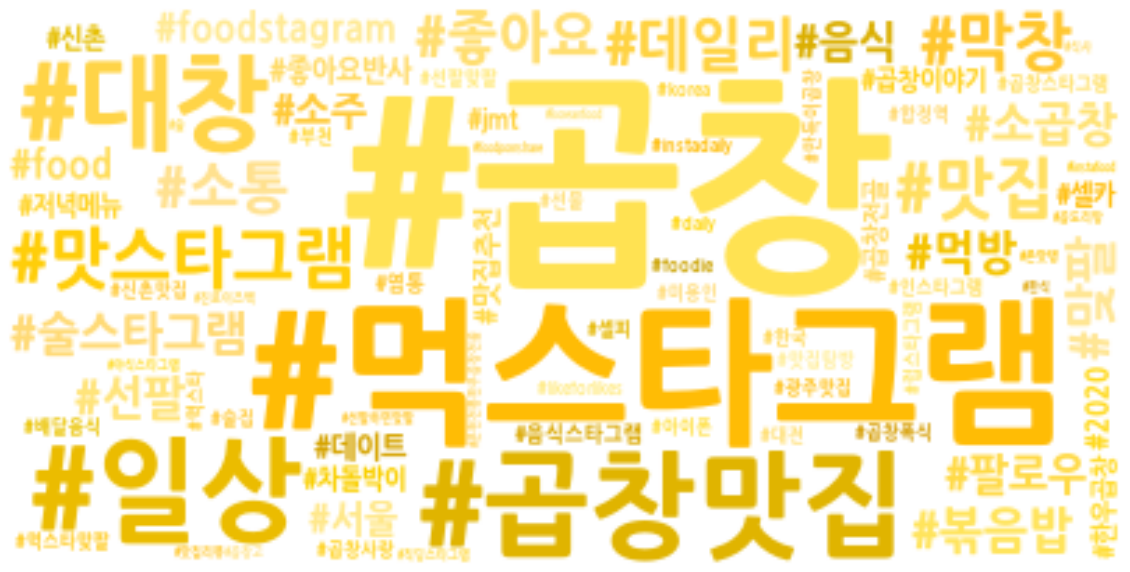

In [43]:
#워드클라우드
import numpy as np
from PIL import Image
from collections import Counter
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline


#컬러 커스터마이징
color_value = [50, 48, 46, 44]
def new_color_func(word, font_size, position,
                   orientation, random_state=None, **kwargs):
    return "hsl(%d,100%%,%d%%)" % (color_value[random.randint(0, 3)],random.randint(40, 80))

#워드클라우드 그리기 (실행할 때마다 구성 조금씩 달라짐)
path = './NanumGothicExtraBold.otf' #한글 폰트 경로 지정하기
wordcloud = WordCloud(font_path=path, max_font_size=80, background_color='white', max_words= 100)
wc = wordcloud.generate_from_frequencies(c)
fig = plt.figure(figsize = (20, 30))
plt.imshow(wc.recolor(color_func=new_color_func, random_state=3), interpolation='bilinear')
plt.axis("off")
plt.show()